# Game theory: Finale

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from cmaes import CMA
%matplotlib inline

## Simplex method implementation

In [2]:
def recognition(constraints: list):
    contradictions = []
    for i in range(len(constraints)):
        if (constraints[i][-1] == "<=" and constraints[i][-2] < 0) or (
                constraints[i][-1] == ">=" and constraints[i][-2] > 0):
            return True
    return False

In [4]:
def get_table_single_phase(constraints: list, b: np.array):
    col_num = len(constraints) + len(b) + 1
    row_num = 1 + len(constraints)
    table = np.zeros((row_num, col_num))

    row_to_name = {}
    col_to_name = {}
    name_to_value = {}
    
    for k in range(len(constraints)):
        col_to_name[k] = "l" + str(k)
    
    for k in range(len(constraints), col_num - 1):
        col_to_name[k] = "x" + str(k - len(constraints))
    
    for k in range(len(constraints)):
        row_to_name[k] = "l" + str(k) 

    for k in range(len(constraints)):
        if constraints[k][-1] == "<=" or constraints[k][-1] == "=":
            name_to_value["l" + str(k)] = constraints[k][-2]
        else:
            name_to_value["l" + str(k)] = -constraints[k][-2]

    for k in range(len(b)):
        name_to_value["x" + str(k)] = 0

    for i in range(len(constraints)):
        table[i][i] = 1

    for j in range(len(constraints), col_num - 1):
        for i in range(row_num - 1):
            table[i][j] = constraints[i][j - len(constraints)]

    for i in range(row_num - 1):
        table[i][-1] = name_to_value["l" + str(i)]

    table[row_num - 1][-1] = 0

    new_b = np.zeros(col_num - 1)
    for k in range(len(constraints), len(b) + len(constraints)):
        new_b[k] = b[k - len(constraints)]

    for j in range(len(constraints), col_num - 1):
        table[-1][j] = np.dot(table.T[j][:-1], new_b[:len(constraints)]) - new_b[j]

    return table, name_to_value, row_to_name, col_to_name

In [5]:
def get_r_and_constraints(constraints_old, b_old):
    constraints = copy.deepcopy(constraints_old)
    for i in range(len(constraints_old)):
        for k in range(len(constraints_old)):
            constraints[i].append(0)
        constraints[i][len(constraints_old)], constraints[i][-1] = constraints[i][-1], constraints[i][
            len(constraints_old)]
        constraints[i][len(constraints_old) - 1], constraints[i][-2] = constraints[i][-2], constraints[i][
            len(constraints_old) - 1]

        constraints[i][i + len(constraints_old) - 1] = (-1 if constraints_old[i][-1] == ">=" else 1)

    b = [0] * (len(constraints[0]) - 2)
    for j in range(len(constraints[0]) - 2):
        for i in range(len(constraints)):
            b[j] -= constraints[i][j]
    return constraints, b

In [6]:
def get_table_two_phase(constraints: list, b: np.array):
    col_num = 2 * len(constraints) + len(b) + 1
    row_num = 2 + len(constraints)
    table = np.zeros((row_num, col_num))

    row_to_name = {}
    col_to_name = {}
    name_to_value = {}
    
    for k in range(len(constraints)):
        col_to_name[k] = "l" + str(k)
    
    for k in range(len(constraints), 2 * len(constraints)):
        col_to_name[k] = "r" + str(k - len(constraints))

    for k in range(2 * len(constraints), col_num):
        col_to_name[k] = "x" + str(k - 2 * len(constraints))
    
    for k in range(len(constraints)):
        row_to_name[k] = "r" + str(k) 

    for k in range(len(constraints)):
        name_to_value["r" + str(k)] = constraints[k][-2]
        name_to_value["l" + str(k)] = 0

    for k in range(len(b)):
        name_to_value["x" + str(k)] = 0

    for i in range(len(constraints), 2 * len(constraints)): # заполняем t_ij для r_k
        table[i - len(constraints)][i] = 1

    for j in range(len(constraints)): # заполняем t_ij для l_k
        if constraints[j][-1] == "<=" or constraints[j][-1] == "=":
            table[j][j] = 1
        else:
            table[j][j] = -1

    for j in range(2 * len(constraints), col_num - 1): # заполняем t_ij для x_k
        for i in range(row_num - 2):
            table[i][j] = constraints[i][j - 2 * len(constraints)]

    for i in range(row_num - 2):
        table[i][-1] = name_to_value["r" + str(i)]

    for j in range(2 * len(constraints), col_num - 1): # заполняем предпоследнюю строку для x_k
        table[-2][j] = -b[j - 2 * len(constraints)]

    table[-2][-1] = 0

    for j in range(len(constraints)): # заполняем последнюю строку для l_k
        if constraints[j][-1] == "<=" or constraints[i][-1] == "=":
            table[-1][j] = 1
        else:
            table[-1][j] = -1

    for j in range(2 * len(constraints), col_num - 1): # заполняем последнюю строку для x_k
        sum_ = sum([float(x) for x in np.array(constraints).T[:][j - 2 * len(constraints)]])
        table[-1][j] = sum_

    table[-1][-1] = sum([name_to_value["r" + str(k)] for k in range(len(constraints))])

    return table, name_to_value, row_to_name, col_to_name

In [7]:
def delete_col(table, col_to_name: dict, i: int):
    table = np.delete(table, i, axis=1)
    for j in range(i + 1, len(col_to_name)):
        col_to_name[j - 1] = col_to_name[j]
    col_to_name.pop(len(col_to_name) - 1)
    return table, col_to_name

In [8]:
def trim_table(table, name_to_value: dict, row_to_name: dict, col_to_name: dict):
    to_del = []
    for i in col_to_name:
        if col_to_name[i][0] == "r":
            to_del.append(i)
        if i < len(table) - 2:
           name_to_value.pop("r" + str(i))

    for i in range(len(to_del)):
        table, col_to_name = delete_col(table, col_to_name, to_del[i] - i)
    table = np.delete(table, len(table) - 1, axis=0)
    return table, name_to_value, row_to_name, col_to_name

In [9]:
def can_be_improved(table):
    return any(x > 0 for x in table[-1][:-1])

In [10]:
def get_pivot_position_single_phase(table):
    col_num = len(table[0])
    row_num = len(table)
    
    min_divided = float('inf')
    min_index = (-1, -1)
    
    for j in range(col_num - 1):
        if table[-1][j] > 0:
            for i in range(row_num - 1):
                if table[i][j] > 0:
                    cur_divided = table[i][-1] / table[i][j]
                    if cur_divided < min_divided:
                        min_index = (i, j)
                        min_divided = cur_divided
            
    
    return min_index # returns (-1, -1) if all table[i][j] < 0            
            

In [11]:
def get_pivot_position_two_phase(table):
    col_num = len(table[0])
    row_num = len(table)

    min_divided = float('inf')
    min_index = (-1, -1)

    for j in range(col_num - 1):
        if table[-1][j] > 0:
            for i in range(row_num - 2):
                if table[i][j] > 0:
                    cur_divided = table[i][-1] / table[i][j]
                    if cur_divided < min_divided:
                        min_index = (i, j)
                        min_divided = cur_divided

    return min_index  # returns (-1, -1) if all table[i][j] < 0

In [12]:
def simplex_step_single_phase(table, row_to_name: dict, col_to_name: dict, name_to_value: dict):
    col_num = len(table[0])
    row_num = len(table)
    
    i, j = get_pivot_position_single_phase(table)
    if (i, j) == (-1, -1):
        return None
    row = table[i] / table[i][j]

    for k in range(row_num - 1):
        if k == i:
            continue
        table[k] -= table[k][j] * row
        name_to_value[row_to_name[k]] = table[k][-1]

    table[i] /= table[i][j]
    name_to_value[row_to_name[i]] = table[i][-1]

    table[-1] -= table[-1][j] * row
    
    # print("col_to_name ", col_to_name)
    # print("row_to_name ", row_to_name)
        
    v1 = name_to_value.get(row_to_name.get(i))
    v2 = name_to_value.get(col_to_name.get(j))
    name_to_value[row_to_name[i]] = v2
    name_to_value[col_to_name[j]] = v1
    
    
    v3 = row_to_name.get(i)
    v4 = col_to_name.get(j)
    row_to_name[i] = v4
    col_to_name[j] = v3

    return row_to_name, col_to_name, name_to_value
    

In [13]:
def simplex_step_two_phase(table, row_to_name: dict, col_to_name: dict, name_to_value: dict):
    col_num = len(table[0])
    row_num = len(table)

    i, j = get_pivot_position_two_phase(table)
    if (i, j) == (-1, -1):
        return None

    row = table[i] / table[i][j]

    for k in range(row_num - 2):
        if k == i:
            continue
        table[k] -= table[k][j] * row
        name_to_value[row_to_name[k]] = table[k][-1]

    table[i] /= table[i][j]
    name_to_value[row_to_name[i]] = table[i][-1]
    table[-2] -= table[-2][j] * row
    table[-1] -= table[-1][j] * row

    # print("col_to_name ", col_to_name)
    # print("row_to_name ", row_to_name)

    v1 = name_to_value[row_to_name[i]]
    v2 = name_to_value[col_to_name[j]]
    name_to_value[row_to_name[i]] = v2
    name_to_value[col_to_name[j]] = v1


    v4 = col_to_name[j]
    row_to_name[i] = v4


    return row_to_name, col_to_name, name_to_value

In [14]:
def simplex_method(constraints: list, b: np.array):
    zero_solution = not recognition(constraints)

    if zero_solution:
        table, name_to_value, row_to_name, col_to_name = get_table_single_phase(constraints, b)

        while can_be_improved(table):
            if simplex_step_single_phase(table, row_to_name, col_to_name, name_to_value) == None:
                # print("there is no solution")
                return None, None, None, None
    else:
        table, name_to_value, row_to_name, col_to_name = get_table_two_phase(constraints, b)

        while can_be_improved(table):
            if simplex_step_two_phase(table, row_to_name, col_to_name, name_to_value) == None:
                print("there is no solution because pivot index does not exist")
                return None, None, None, None

        flag = True

        if any(row_to_name[q][0] == "r" for q in range(len(constraints))):
            print("there is no solution because some r_k are not zero")
            return None, None, None, None


        if flag:
            table, name_to_value, row_to_name, col_to_name = trim_table(table, name_to_value, row_to_name, col_to_name)

            # print("all cool")
            while can_be_improved(table):
                if simplex_step_single_phase(table, row_to_name, col_to_name, name_to_value) == None:
                    print("there is no solution")
                    return None, None, None, None

    return table, row_to_name, col_to_name, name_to_value

In [15]:
def optimize(constraints, b):
    table, row_to_name, col_to_name, name_to_value = simplex_method(constraints, b)
    x = []
    if table is None:
        return None
    for i in range(len(b)):
        x.append(name_to_value["x" + str(i)])
    return x

### Example 1

In [16]:
constraints = [[1, 1, 3, "<="], 
               [1, 2, 5, "<="],
               [4, 2, 10, "<="]]
b = -np.array([2, 3])
table, name_to_value, row_to_name, col_to_name = get_table_single_phase(constraints, b)

print(table)

[[ 1.  0.  0.  1.  1.  3.]
 [ 0.  1.  0.  1.  2.  5.]
 [ 0.  0.  1.  4.  2. 10.]
 [ 0.  0.  0.  2.  3.  0.]]


In [17]:
table, row_to_name, col_to_name, name_to_value = simplex_method(constraints, b)

In [18]:
table

array([[-1.,  1.,  0.,  0.,  1.,  2.],
       [-6.,  2.,  1.,  0.,  0.,  2.],
       [ 2., -1.,  0.,  1.,  0.,  1.],
       [-1., -1.,  0.,  0.,  0., -8.]])

In [19]:
print(optimize(constraints, b))

[1.0, 2.0]


In [20]:
int(3) - float(2.5)

0.5

### Example 2

In [21]:
b = -np.array([1, 1])
constraints = [[1, 0, 1, "<="], [0, 1, 1, "<="]]

table, name_to_value, row_to_name, col_to_name = get_table_single_phase(constraints, b)
table

array([[1., 0., 1., 0., 1.],
       [0., 1., 0., 1., 1.],
       [0., 0., 1., 1., 0.]])

In [22]:
table, row_to_name, col_to_name, name_to_value = simplex_method(constraints, b)

In [23]:
table

array([[ 1.,  0.,  1.,  0.,  1.],
       [ 0.,  1.,  0.,  1.,  1.],
       [-1., -1.,  0.,  0., -2.]])

In [24]:
name_to_value

{'l0': 0, 'l1': 0, 'x0': 1.0, 'x1': 1.0}

### Example 3

In [25]:
constraints = [[1, 1, 1, ">="],
              [2, -1, 1, ">="],
              [0, 3, 2, "<="]]
b = np.array([6, 3])
table, name_to_value, row_to_name, col_to_name = get_table_two_phase(constraints, b)

In [26]:
table

array([[-1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.],
       [ 0., -1.,  0.,  0.,  1.,  0.,  2., -1.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  3.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -6., -3.,  0.],
       [-1., -1.,  1.,  0.,  0.,  0.,  3.,  3.,  4.]])

In [27]:
table, row_to_name, col_to_name, name_to_value = simplex_method(constraints, b)

In [28]:
table

array([[-0.66666667,  0.33333333,  0.        ,  0.        ,  1.        ,
         0.33333333],
       [-0.33333333, -0.33333333,  0.        ,  1.        ,  0.        ,
         0.66666667],
       [ 2.        , -1.        ,  1.        ,  0.        ,  0.        ,
         1.        ],
       [-4.        , -1.        ,  0.        ,  0.        ,  0.        ,
         5.        ]])

In [29]:
name_to_value

{'l0': 0,
 'l1': 0,
 'l2': 1.0,
 'x0': 0.6666666666666666,
 'x1': 0.3333333333333333}

### Example 4

In [30]:
b = -np.array([5000, 2500])
constraints = [[4, 1.5, 24, "<="],
              [1200, 150, 6000, "<="],
              [20, 20, 200, "<="],
              [1, 0, 2, ">="]]

In [31]:
table, row_to_name, col_to_name, name_to_value = simplex_method(constraints, b)
table

array([[-4.0e-01,  0.0e+00,  8.0e-02,  0.0e+00,  0.0e+00,  1.0e+00,
         6.4e+00],
       [ 4.0e-01,  0.0e+00, -3.0e-02,  1.0e+00,  0.0e+00,  0.0e+00,
         1.6e+00],
       [-4.2e+02,  1.0e+00,  2.4e+01,  0.0e+00,  0.0e+00,  0.0e+00,
         7.2e+02],
       [ 4.0e-01,  0.0e+00, -3.0e-02,  0.0e+00,  1.0e+00,  0.0e+00,
         3.6e+00],
       [-1.0e+03,  0.0e+00, -5.0e+01,  0.0e+00,  0.0e+00,  0.0e+00,
        -3.4e+04]])

In [32]:
name_to_value

{'l0': 0, 'l1': 719.9999999999999, 'l2': 0, 'l3': 1.6, 'x0': 3.6, 'x1': 6.4}

### Example 5

In [33]:
b = -np.array([2, 5])
constraints = [[3, 2, 6, ">="],
              [1, 2, 4, "<="]]

In [34]:
table, row_to_name, col_to_name, name_to_value = simplex_method(constraints, b)
table

array([[-0.5 , -0.5 ,  1.  ,  0.  ,  1.  ],
       [ 0.25,  0.75,  0.  ,  1.  ,  1.5 ],
       [-0.25, -2.75,  0.  ,  0.  , -9.5 ]])

In [35]:
name_to_value

{'l0': 0, 'l1': 0, 'x0': 1.0000000000000002, 'x1': 1.4999999999999998}

### Example 6

In [36]:
b = -np.array([3, 4])
constraints = [[1, 0, 6, "="],
              [0, 1, 6, "<="]]

In [37]:
table, row_to_name, col_to_name, name_to_value = simplex_method(constraints, b)
table

array([[  1.,   0.,   1.,   0.,   6.],
       [  0.,   1.,   0.,   1.,   6.],
       [ -3.,  -4.,   0.,   0., -42.]])

In [38]:
name_to_value

{'l0': 0, 'l1': 0, 'x0': 6.0, 'x1': 6.0}

## Mixed-integer linear programming

In [70]:
def func(b, x):
    if x is None:
        return math.inf
    s = 0
    for i in range(len(b)):
        s += b[i] * x[i]
    return int(s)

In [71]:
def milp(integer_vars, constraints, b):
    """Mixed-integer linear programming problem solution using Branch and Bound and Simplex methods"""
    
    x = optimize(constraints, b)
    non_integer_vars = [] # list to store indices of non-integer x_k
    
    if x is None: # if simplex method didn't find solution then there is no mixed-integer solution
        return None

    for i in integer_vars:
        if (abs(x[i] - round(x[i])) > 1e-6): # check if x_i is integer
            non_integer_vars.append(i) 
            
    if len(non_integer_vars) == 0: # self-explanatory 
        return x
        
    x1 = int(x[non_integer_vars[0]]) # compute floor of non-integer x

    # create lists for the purpose of branching the feasible region
    left_constraint = [0] * (len(constraints[0]) - 1)
    right_constraint = [0] * (len(constraints[0]) - 1)
    
    left_constraint[non_integer_vars[0]] = 1
    right_constraint[non_integer_vars[0]] = 1
    left_constraint[-1] = x1
    right_constraint[-1] = x1 + 1
    left_constraint.append("<=")
    right_constraint.append(">=")
    
    constraints.append(left_constraint)
    opt1 = milp(integer_vars, constraints, b)
    constraints.pop(-1)
    
    constraints.append(right_constraint)
    opt2 = milp(integer_vars, constraints, b)
    constraints.pop(-1)
    
    if opt1 is None and opt2 is None:
        return None
    if (func(b, opt1) < func(b, opt2)):
        return opt1
        
    return opt2

### Example 1

In [72]:
b = -np.array([0, 1])
constraints = [[-1, 1, 1, "<="],
              [3, 2, 12, "<="],
              [2, 3, 12, "<="]]
integer_vars = [0, 1]

In [73]:
print(milp(integer_vars, constraints, b))

there is no solution because some r_k are not zero
[2.0, 2.0]


### Parser of .mps files

In [43]:
from mip import Model
from scipy.sparse import csr_matrix

In [44]:
def read_mps(file: str):
    """
    Reads a .mps and saves all the data of the MILP:

    min c^T * x

    s.t. b_l <= A*x <= b_u
          lb <=   x <= ub
                x_i integer if integrality[i] = 1
    """
    mdl = Model(solver_name="CBC")
    mdl.read(file)

    # model parameters
    num_vars = len(mdl.vars)
    num_cons = len(mdl.constrs)

    # variable types and bounds
    lb = np.zeros(num_vars)
    ub = np.inf * np.ones(num_vars)
    integrality = np.zeros(num_vars)
    for i, var in enumerate(mdl.vars):
        lb[i] = var.lb
        ub[i] = var.ub
        if var.var_type != "C":
            integrality[i] = 1

    # objective
    c = np.zeros(num_vars)
    for i, var in enumerate(mdl.vars):
        if var in mdl.objective.expr:
            c[i] = mdl.objective.expr[var]
    if mdl.sense != "MIN":
        c *= -1.0

    # constraint coefficient matrix
    b_l = -np.inf * np.ones((num_cons))
    b_u = np.inf * np.ones((num_cons))
    row_ind = []
    col_ind = []
    data = []
    for i, con in enumerate(mdl.constrs):
        if con.expr.sense == "=":
            b_l[i] = con.rhs
            b_u[i] = con.rhs
        elif con.expr.sense == "<":
            b_u[i] = con.rhs
        elif con.expr.sense == ">":
            b_l[i] = con.rhs
        for j, var in enumerate(mdl.vars):
            if var in (expr := con.expr.expr):
                coeff = expr[var]
                row_ind.append(i)
                col_ind.append(j)
                data.append(coeff)
    A = csr_matrix((data, (row_ind, col_ind)), shape=(num_cons, num_vars))
    return c, b_l, A, b_u, lb, ub, integrality,


# return constrainst, b, int_var
def parse(path):
    c, b_l, A, b_u, lb, ub, integrality = read_mps(path)
    constraints1 = A.toarray().tolist()
    constraints2 = A.toarray().tolist()
    print(b_l)
    print(b_u)


    constraints = []
    n = len(constraints1)
    m = len(constraints1[0])
    for i in range(n):
        constraints1[i].append(0)
        constraints2[i].append(0)
        constraints1[i][-1] = b_l[i]
        constraints2[i][-1] = b_u[i]
        constraints1[i].append(">=")
        constraints2[i].append("<=")
        if constraints1[i][-2] > -1e+300:
            constraints.append(constraints1[i])
        if constraints2[i][-2] < 1e+300:
            constraints.append(constraints2[i])
    for i in range(m):
        constraint1 = [0] * (m + 1)
        constraint2 = [0] * (m + 1)
        constraint1[i] = 1
        constraint2[i] = 1
        constraint1[-1] = lb[i]
        constraint2[-1] = ub[i]
        constraint1.append(">=")
        constraint2.append("<=")
        if constraint1[-2] > -1e+300:
            constraints.append(constraint1)
        if constraint2[-2] < 1e+300:
            constraints.append(constraint2)
    return constraints, c, integrality

In [45]:
path = '/Users/skyrex/Downloads/ej.mps'
A, c, integrality = parse(path)
for a in A:
    print(a)
print(-c)

print(optimize(A, -c))

An error occurred while loading the CBC library:	 cannot load library '/Users/skyrex/anaconda3/envs/NN/lib/python3.9/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib': dlopen(/Users/skyrex/anaconda3/envs/NN/lib/python3.9/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib, 0x0002): tried: '/Users/skyrex/anaconda3/envs/NN/lib/python3.9/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/skyrex/anaconda3/envs/NN/lib/python3.9/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (no such file), '/Users/skyrex/anaconda3/envs/NN/lib/python3.9/site-packages/mip/libraries/cbc-c-darwin-x86-64.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')).  Additionally, ctypes.util.find_library() did not manage to locate a library called '/Users/skyrex/anaconda3/envs/NN/lib/python3.9/site-packages/mip/libraries/cbc-c-darwin-x86-64.dy

NameError: name 'cbclib' is not defined

## Levi function optimization

In [46]:
def make_levi_func(n):
    def first_comp(x):
        return (np.sin(3 * np.pi * x)) ** 2
    
    def second_comp(x, y, k):
        return ((x - 1) ** 2) * (1 + np.sin(k * np.pi * y) ** 2)
    
    def res_func(x: list):
        assert len(x) == n
        s = first_comp(x[0])
        for k in range(n):
            s += second_comp(x[k], x[-1], n - k + 1)
        return s
    
    return res_func  

In [47]:
def expected_value(x: np.array):
    return sum(x) / len(x)

def variance(x: np.array):
    return expected_value(np.square((x - expected_value(x))))

def sigma(x: np.array):
    return np.sqrt(variance(x))

In [48]:
def confidence_interval(x: np.array):
    z = 1.96
    s = sigma(x)
    n = len(x)
    avg = expected_value(x)

    return (avg - z * s / np.sqrt(n), avg + z * s / np.sqrt(n))

In [54]:
def main_n_dim(n, f):
    seed = 0
    rng = np.random.RandomState(0)

    b = []
    for i in range(n):
        b.append([-10, 10])

    bounds = np.array(b)
    lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]

    mean = lower_bounds + (np.random.rand(n) * (upper_bounds - lower_bounds))
#     print("mean", mean)
    sigma = 20 / 5  # 1/5 of the domain width
    optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=seed)

    n_restarts = 0  # A small restart doesn't count in the n_restarts
    small_n_eval, large_n_eval = 0, 0
    popsize0 = optimizer.population_size
    inc_popsize = 2

    # Initial run is with "normal" population size; it is
    # the large population before first doubling, but its
    # budget accounting is the same as in case of small
    # population.
    poptype = "small"

    function_value = []

    while n_restarts <= 2:
        solutions = []
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            value = f(x)
            solutions.append((x, value))
            # print("{:10.5f}  {:6.2f}  {:6.2f}".format(value, x[0], x[1]))
        optimizer.tell(solutions)
        function_value.append(min([v for arr, v in solutions]))

        if len(function_value) > 2 and abs(function_value[-1] - function_value[-2]) < 1e-15:
            return solutions, function_value

        if optimizer.should_stop():
            seed += 1
            n_eval = optimizer.population_size * optimizer.generation
            if poptype == "small":
                small_n_eval += n_eval
            else:  # poptype == "large"
                large_n_eval += n_eval

            if small_n_eval < large_n_eval:
                poptype = "small"
                popsize_multiplier = inc_popsize ** n_restarts
                popsize = math.floor(
                    popsize0 * popsize_multiplier ** (np.random.uniform() ** 2)
                )
            else:
                poptype = "large"
                n_restarts += 1
                popsize = popsize0 * (inc_popsize ** n_restarts)

            mean = lower_bounds + (np.random.rand(n) * (upper_bounds - lower_bounds))

            optimizer = CMA(
                mean=mean,
                sigma=sigma,
                bounds=bounds,
                seed=seed,
                population_size=popsize,
            )
            # print("Restart CMA-ES with popsize={} ({})".format(popsize, poptype))


    # for sol in solutions:
    #     print(sol)

    return solutions, function_value

### Confidence interval plotting

In [53]:
def test_optimizer(n, iter_num):
    y_min = []
    y_max = []
    optimal = []
    values = []

    epochs = []
    for k in range(iter_num):
        solutions, function_value = main_n_dim(n, make_levi_func(n))

        while len(epochs) < len(function_value):
            epochs.append([])

        for i in range(len(function_value)):
            epochs[i].append(function_value[i])

    mean = [expected_value(epochs[k]) for k in range(len(epochs))]

    for k in range(len(epochs)):
        left, right = confidence_interval(epochs[k])

        y_min.append(left)
        y_max.append(right)



    return y_min, y_max, mean



In [62]:
def plot_confidence_interval(n, iter_num):
    Y_min, Y_max, optimal = test_optimizer(n, iter_num)

    x = np.linspace(0, len(optimal), len(optimal))

    plt.plot(optimal, label="optimal")

    plt.fill_between(x, Y_min, Y_max, color='r', alpha=.1, label="confidence interval")

    plt.xlabel("epoch number")
    plt.yscale('linear')
    plt.legend()


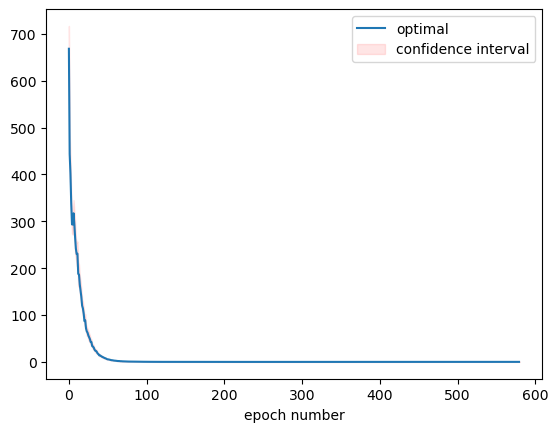

In [69]:
plot_confidence_interval(20, 20)

In [76]:
def foo():
    print('it is cringe')

In [74]:
s = main_n_dim(100, make_levi_func(100))

In [75]:
s

([(array([0.99999999, 1.00000001, 1.00000003, 1.00000004, 0.99999992,
          0.99999993, 0.99999994, 1.00000001, 1.00000007, 1.00000008,
          0.99999996, 1.        , 1.00000004, 0.99999992, 1.00000001,
          1.00000007, 0.99999997, 0.99999998, 1.00000008, 0.99999988,
          0.99999998, 0.99999998, 0.99999992, 1.00000018, 0.99999991,
          0.99999999, 0.99999995, 0.99999994, 0.99999989, 0.99999989,
          1.00000001, 0.99999996, 1.0000001 , 0.99999993, 0.99999992,
          1.00000002, 0.99999993, 1.00000005, 0.99999995, 1.00000011,
          1.00000006, 1.00000001, 1.00000005, 1.00000004, 0.99999992,
          1.00000006, 1.00000005, 0.99999998, 0.99999994, 1.00000002,
          1.00000008, 1.00000001, 1.00000009, 0.99999997, 1.00000002,
          1.00000003, 0.99999997, 0.99999998, 1.00000003, 1.        ,
          1.00000001, 0.99999998, 1.00000001, 0.99999999, 0.99999999,
          1.00000002, 0.99999983, 1.00000006, 1.00000006, 1.00000002,
          1.00000005